
sources: 
* [tutorial by Mauro Di Pietro, 2020](https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec)
* [tutorial by Rafi Atha, 2021](https://medium.com/analytics-vidhya/building-classification-model-with-python-9bdfc13faa4b)


TODO: 
* see also data science of EEG , correlation 
* use tutorials: 
https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
* https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0
* https://towardsdatascience.com/how-to-run-30-machine-learning-models-with-2-lines-of-code-d0f94a537e52
* https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html


## Load data

In [2]:
from google.colab import files, drive
import pandas as pd

In [3]:
drive.mount('/content/drive')

def read_data(data_name): 

  data_path = "/content/drive/MyDrive/eeg_data_science/Results/5.For_Modeling/"
  return pd.read_csv(data_path + data_name +'.csv')

X = read_data('X')
y = read_data('y')
X_raw = X
y_raw = y

Mounted at /content/drive


## Prapere for modeling

In [119]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import random
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, tree, naive_bayes, neighbors, svm
## for explainer
!pip install lime
from lime import lime_tabular

Text(0.5, 1.0, 'Class Distribution')

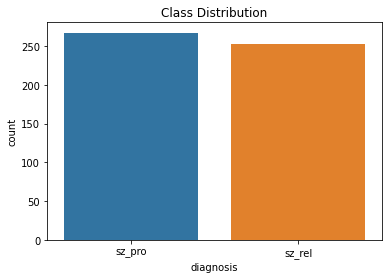

In [5]:
ax = sns.countplot(x="diagnosis", data=y_raw)
plt.title("Class Distribution")

In [6]:
X_raw.isnull().sum().sum()

0

In [7]:
# TODO: should not be here - remove in former notebook
X = X.drop(columns=['Unnamed: 0', 'sub_num'])

In [8]:
## create dummy
'''
# I did not use it becuase it made pro = 0 and rel = 1, which is the opposit of what make sense
y_dummy = pd.get_dummies(y["diagnosis"], prefix="diagnosis",drop_first=True)
y_dummy = np.array(y_dummy['diagnosis_sz_rel'])
y_dummy
'''

'\n# I did not use it becuase it made pro = 0 and rel = 1, which is the opposit of what make sense\ny_dummy = pd.get_dummies(y["diagnosis"], prefix="diagnosis",drop_first=True)\ny_dummy = np.array(y_dummy[\'diagnosis_sz_rel\'])\ny_dummy\n'

In [9]:
from sklearn.preprocessing import StandardScaler

X_scaled = X.copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

diag_map = {'sz_pro': 1, 'sz_rel': 0}
y_dummy = y['diagnosis'].map(diag_map)

X_safe = X
y_safe = y_dummy

def default_data():
  
  feature_names = X_safe.columns
  X = X_scaled
  y = y_safe

  return X, y, feature_names

## Statistics

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [315 319 323 327 331 335] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


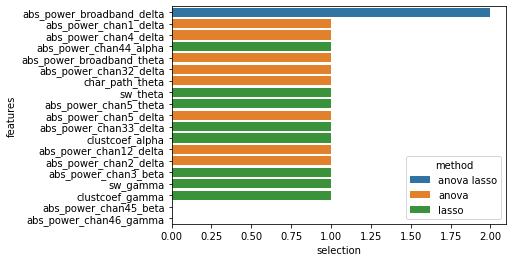

In [10]:
X, y, feature_names = default_data()

## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=10).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]

## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False)[1:20], dodge=False) 

# Modeling

In [11]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3)

models_results = pd.DataFrame(columns=['Metric', 'Score', 'Model'])

In [12]:
def train_test_eval(model_name, model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  print('\033[1m' + 'Model'+'\033[0m')
  display(model)
  print()

  # test 
  results = evaluate_model(model, X_test, y_test)

  # show result
  print('\033[1m' + 'Results'+'\033[0m')
  cm_pos = list(results['Metric'].values()).index('cm')
  plot_confusion_matrix(results['Score'][cm_pos], model_name)

  # save results 
  del results['Metric'][cm_pos]
  del results['Score'][cm_pos]

  res_df = pd.DataFrame(results)
  res_df.insert(2, "Model", model_name)
  display(res_df)
  return res_df

In [147]:
def evaluate_model(model, X_test, y_test):
# source: https://gist.github.com/rafiag/350ec2dee0fb311d3342197b6c8424b5#file-evaluation_function-py

    # Predict Test Data 
    y_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    if  hasattr(model, 'name'): 
      if model.name == 'LinearSVC': 
        y_pred_proba = model.decision_function(X_test) 
    else: 
      y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    results = {'Metric': {0: 'Accuracy', 1: 'Precision', 2: 'Recall', 3: 'F1', 4: 'Kappa', 5: 'fpr', 6: 'tpr', 7: 'AUC', 8: 'cm'}, 
               'Score': {0: acc, 1: prec, 2: rec, 3: f1, 4: kappa, 5: [fpr],  6: [tpr], 7: auc, 8: cm}} 
    return results

In [14]:
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

def plot_confusion_matrix(cm, classifier):

  classes = ['sz_rel', 'sz_pro']
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', cmap=random.choice(cmaps), cbar=False)
  ax.set(xlabel="Predicted", ylabel="True", title=f"Confusion Matrix - {classifier}")
  ax.set_yticklabels(labels=classes, rotation=0)
  ax.set_xticklabels(labels=classes)
  plt.show()

## Linear

Model


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


Results


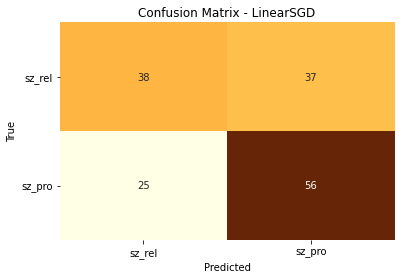

,Metric,Score,Model
0,Accuracy,0.602564,LinearSGD
1,Precision,0.602151,LinearSGD
2,Recall,0.691358,LinearSGD
3,F1,0.643678,LinearSGD
4,Kappa,0.199205,LinearSGD
5,fpr,"[[0.0, 0.013333333333333334, 0.013333333333333...",LinearSGD
6,tpr,"[[0.0, 0.012345679012345678, 0.037037037037037...",LinearSGD
7,AUC,0.58856,LinearSGD


In [148]:
model = linear_model.SGDClassifier(loss='log')
results = train_test_eval('LinearSGD', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## SVM

Model


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)


Results


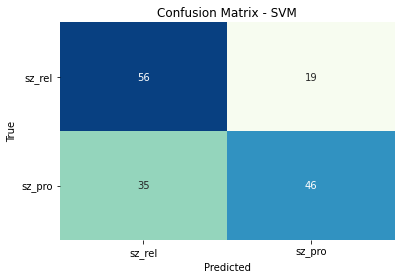

,Metric,Score,Model
0,Accuracy,0.653846,SVM
1,Precision,0.707692,SVM
2,Recall,0.567901,SVM
3,F1,0.630137,SVM
4,Kappa,0.312102,SVM
5,fpr,"[[0.0, 0.013333333333333334, 0.013333333333333...",SVM
6,tpr,"[[0.0, 0.0, 0.09876543209876543, 0.09876543209...",SVM
7,AUC,0.738436,SVM


In [149]:
model = svm.LinearSVC(random_state=0)
model.name = 'LinearSVC'
results = train_test_eval('SVM', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

'k'

## Decision Tree

Model


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


Results


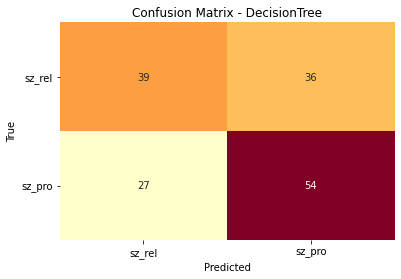

,Metric,Score,Model
0,Accuracy,0.596154,DecisionTree
1,Precision,0.6,DecisionTree
2,Recall,0.666667,DecisionTree
3,F1,0.631579,DecisionTree
4,Kappa,0.1875,DecisionTree
5,fpr,"[[0.0, 0.48, 1.0]]",DecisionTree
6,tpr,"[[0.0, 0.6666666666666666, 1.0]]",DecisionTree
7,AUC,0.593333,DecisionTree


In [15]:
model = tree.DecisionTreeClassifier(random_state=0)
results = train_test_eval('DecisionTree', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## Random Forest

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Model


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


Results


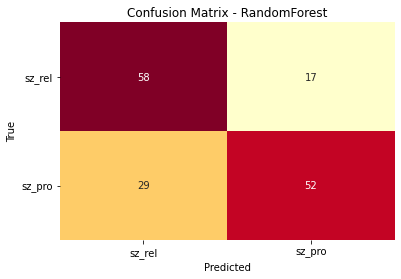

,Metric,Score,Model
0,Accuracy,0.705128,RandomForest
1,Precision,0.753623,RandomForest
2,Recall,0.641975,RandomForest
3,F1,0.693333,RandomForest
4,Kappa,0.412862,RandomForest
5,fpr,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.01333333333333333...",RandomForest
6,tpr,"[[0.0, 0.012345679012345678, 0.049382716049382...",RandomForest
7,AUC,0.786831,RandomForest


In [16]:
model = ensemble.RandomForestClassifier(random_state=0)
results = train_test_eval('RandomForest', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. 

Model


GaussianNB(priors=None, var_smoothing=1e-09)


Results


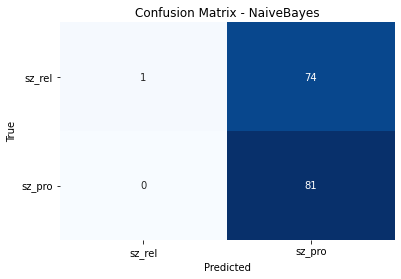

,Metric,Score,Model
0,Accuracy,0.525641,NaiveBayes
1,Precision,0.522581,NaiveBayes
2,Recall,1,NaiveBayes
3,F1,0.686441,NaiveBayes
4,Kappa,0.0138391,NaiveBayes
5,fpr,"[[0.0, 0.05333333333333334, 0.0533333333333333...",NaiveBayes
6,tpr,"[[0.0, 0.1728395061728395, 0.19753086419753085...",NaiveBayes
7,AUC,0.611687,NaiveBayes


In [17]:
model = naive_bayes.GaussianNB()
results = train_test_eval('NaiveBayes', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## K-Nearest Neighbors

K-Nearest Neighbors (KNN) classify new data by finding k-number of closest neighbor from the training data and then decide the class based on the majority of it's neighbors.

Model


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')


Results


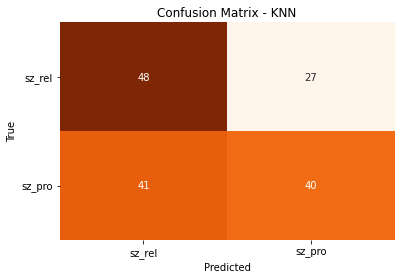

,Metric,Score,Model
0,Accuracy,0.564103,KNN
1,Precision,0.597015,KNN
2,Recall,0.493827,KNN
3,F1,0.540541,KNN
4,Kappa,0.132908,KNN
5,fpr,"[[0.0, 0.04, 0.10666666666666667, 0.36, 0.7333...",KNN
6,tpr,"[[0.0, 0.07407407407407407, 0.2345679012345679...",KNN
7,AUC,0.581235,KNN


In [18]:
model = neighbors.KNeighborsClassifier()
results = train_test_eval('KNN', model, X_train, y_train, X_test, y_test)
models_results = models_results.append(results)

## Gradient Boosting - TODO

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced.

In [19]:
## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=100, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

Best Model parameters: {'subsample': 0.75, 'n_estimators': 250, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': 6, 'max_depth': 5, 'learning_rate': 0.15}
Best Model mean accuracy: 0.6759132420091325


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if __name__ == '__main

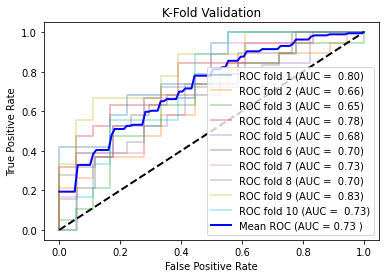

In [20]:
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True)
tprs, aucs = [], []
mean_fpr = np.linspace(0,1,100)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
   prediction = model.fit(X_train[train],y_train.iloc[train]).predict_proba(X_train[test])
   fpr, tpr, t = metrics.roc_curve(y_train.iloc[test], prediction[:, 1])
   tprs.append(scipy.interp(mean_fpr, fpr, tpr))
   roc_auc = metrics.auc(fpr, tpr)
   aucs.append(roc_auc)
   plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC =  %0.2f)' % (i, roc_auc))
   i = i+1
   
plt.plot([0,1], [0,1], linestyle='--', lw=2, color='black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Validation')
plt.legend(loc="lower right")
plt.show()

In [21]:
## train
model.fit(X_train, y_train)
## test
predicted_prob = model.predict_proba(X_test)[:,1]
predicted = model.predict(X_test)

In [22]:
## Accuray e AUC
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob)
print("Accuracy (overall correct predictions):",  round(accuracy,2))
print("Auc:", round(auc,2))
    
## Precision e Recall
recall = metrics.recall_score(y_test, predicted)
precision = metrics.precision_score(y_test, predicted)
print("Recall (all 1s predicted right):", round(recall,2))
print("Precision (confidence when predicting a 1):", round(precision,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted, target_names=[str(i) for i in np.unique(y_test)]))

Accuracy (overall correct predictions): 0.69
Auc: 0.77
Recall (all 1s predicted right): 0.69
Precision (confidence when predicting a 1): 0.7
Detail:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68        75
           1       0.70      0.69      0.70        81

    accuracy                           0.69       156
   macro avg       0.69      0.69      0.69       156
weighted avg       0.69      0.69      0.69       156



# Model Comparison

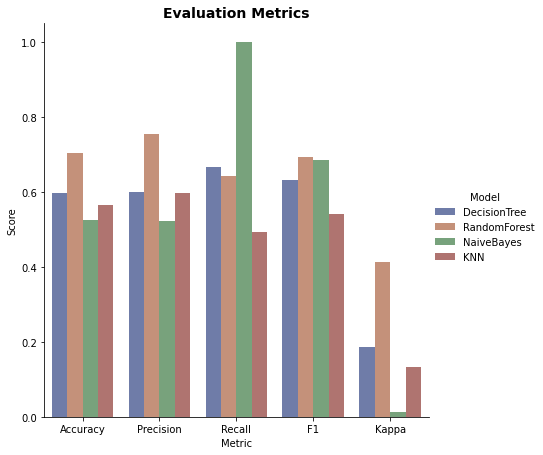

In [109]:
# Scores

cols_scores = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
data_scores = models_results[models_results['Metric'].isin(cols_scores)]
sn = sns.catplot(
    data=data_scores, kind="bar",
    x="Metric", y="Score", hue="Model",
    ci="sd", palette="dark", alpha=.6, height=6
)
ax1.despine(left=True)
ax1.set_axis_labels("", "Score")
ax1.legend.set_title("")

## Create legend & title
plt.title('Evaluation Metrics', fontsize=14, fontweight='bold')

plt.show()

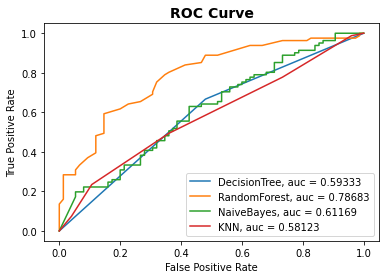

In [107]:
# ROCs

models = models_results['Model'].unique()
for m in models:
  fpr = models_results.loc[(models_results['Model'].isin([m])) & (models_results['Metric'].isin(['fpr']))]['Score']
  tpr = models_results.loc[(models_results['Model'].isin([m])) & (models_results['Metric'].isin(['tpr']))]['Score']
  auc = models_results.loc[(models_results['Model'].isin([m])) & (models_results['Metric'].isin(['AUC']))]['Score']
  plt.plot(list(fpr)[0][0], list(tpr)[0][0], label='{}, auc = {:0.5f}'.format(m, auc.item()))

## Configure x and y axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Create legend & title
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc=4)

plt.show()

# Results (Best Model)

--- TODO: should show results only for the best model 

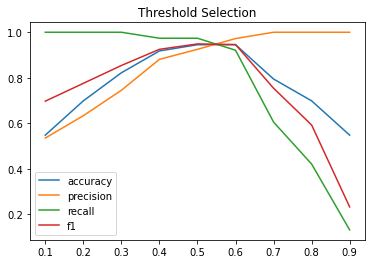

In [ ]:
## calculate scores for different thresholds
dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}
XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(X_train, y_train, test_size=0.2)
predicted_prob = model.fit(XX_train, yy_train).predict_proba(XX_test)[:,1]
thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(metrics.accuracy_score(yy_test, predicted))
    dic_scores["precision"].append(metrics.precision_score(yy_test, predicted))
    dic_scores["recall"].append(metrics.recall_score(yy_test, predicted))
    dic_scores["f1"].append(metrics.f1_score(yy_test, predicted))
        
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))    
dtf_scores.plot(title="Threshold Selection")
plt.show()

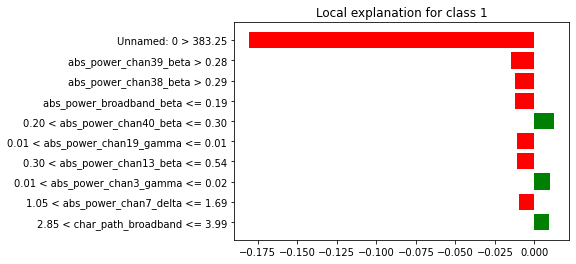

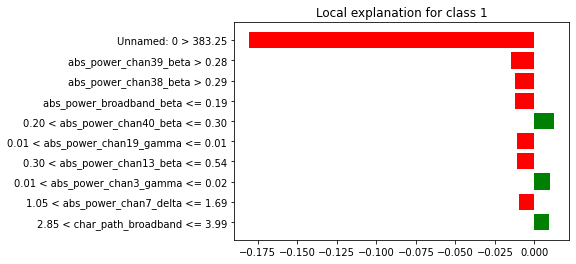

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train, feature_names=feature_names, class_names=np.unique(y_train), mode="classification")
explained = explainer.explain_instance(X_test[4], model.predict_proba, num_features=10)
explained.as_pyplot_figure()

In [ ]:
## PCA
# bad input shape (364, 3) -- maybe try with less features?
pca = decomposition.PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)
X_test_2d = pca.transform(X_test)
## train 2d model
model_2d = ensemble.GradientBoostingClassifier()
model_2d.fit(X_train, y_train)
    
## plot classification regions
from matplotlib.colors import ListedColormap
colors = {np.unique(y_test)[0]:"black", np.unique(y_test)[1]:"green"}
X1, X2 = np.meshgrid(np.arange(start=X_test[:,0].min()-1, stop=X_test[:,0].max()+1, step=0.01),
np.arange(start=X_test[:,1].min()-1, stop=X_test[:,1].max()+1, step=0.01))
fig, ax = plt.subplots()
Y = model_2d.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
ax.contourf(X1, X2, Y, alpha=0.5, cmap=ListedColormap(list(colors.values())))
ax.set(xlim=[X1.min(),X1.max()], ylim=[X2.min(),X2.max()], title="Classification regions")
for i in np.unique(y_test):
    ax.scatter(X_test[y_test==i, 0], X_test[y_test==i, 1], 
               c=colors[i], label="true "+str(i))  
plt.legend()
plt.show()

ValueError: ignored

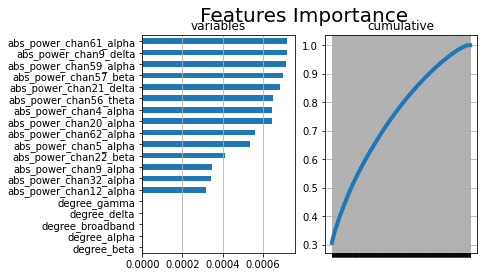

In [12]:
# TODO: see if use this code and where 

X, y, feature_names = default_data()

N_features = 20 
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] = dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')

dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE")[1:N_features].plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels='')
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()